## Group: 11

## Predictive Maintenance

#### Credit: S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

#### Link to dataset: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020

### Group Members:
###### 1) Adithya Harsha: Aharsha@depaul.edu
###### 2) Joao Vitor Lira de Carvalho Firmino: jfirmino@depaul.edu
###### 3) Beemnet Desta: bdesta@depaul.edu


## Dataset Description:

**Features:**

UID: unique identifier

Product ID: L (Low Quality), M (Medium), or H (High) + Number.

Type: Product quality L, M or H from column 2.

Air temperature [K]

Process temperature [K]

Rotational speed [rpm]

Torque [Nm]

Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

Machine failure: 0 (No failure) or 1 (Failure)


**Five independent failure modes:**:

Tool Wear Failure (TWF)

Heat Dissipation Failure (HDF)

Power Failure (PWF)

Overstrain Failure (OSF)

Random Failures (RNF)

## 1) Data Cleaning & Preprocessing:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
main_df = pd.read_csv('ai4i2020.csv')
df = main_df.copy()

main_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [9]:
# Checks for the missing values in each column
missing_values = main_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


There are no missing values in the dataset.

In [10]:
# Checks for the empty strings in categorical columns
empty_productid = (main_df['Product ID'].str.strip() == '').sum()
empty_type = (main_df['Type'].str.strip() == '').sum()

print(f"Number of empty strings in 'Product ID' column: {empty_productid}")
print(f"Number of empty strings in 'Type' column: {empty_type}")

Number of empty strings in 'Product ID' column: 0
Number of empty strings in 'Type' column: 0


There are no empty strings/values in categorical columns 'Product ID' and 'Type'.

In [11]:
# Function to detect the outliers using IQR
def chk_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Detects outliers for numeric columns using IQR
numeric_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

for column in numeric_columns:
    outliers = chk_outliers(main_df, column)
    print(f"Outliers in {column}: {len(outliers)}")

Outliers in Air temperature [K]: 0
Outliers in Process temperature [K]: 0
Outliers in Rotational speed [rpm]: 418
Outliers in Torque [Nm]: 69
Outliers in Tool wear [min]: 0


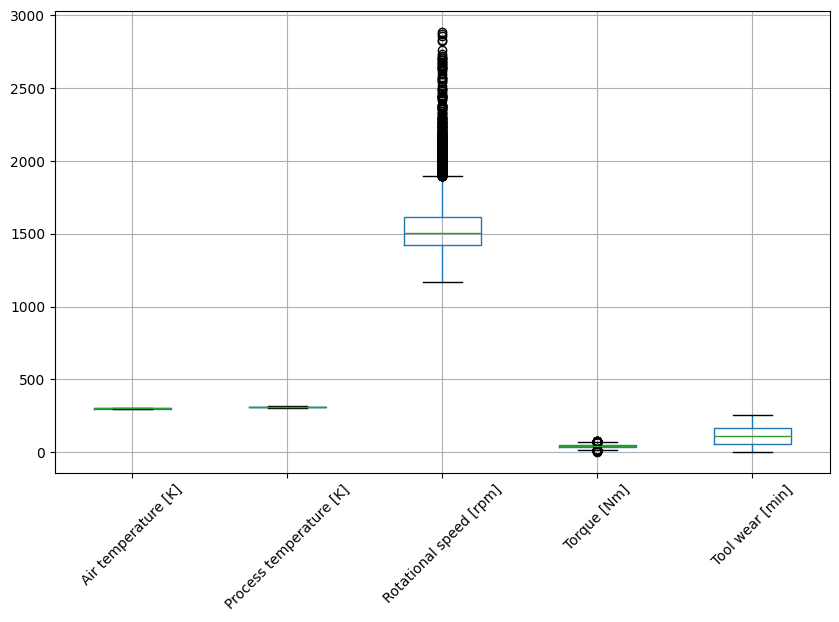

In [12]:
# Visualizes data using boxplot for outliers
plt.figure(figsize = (10, 6))
main_df.boxplot(column = numeric_columns)
plt.xticks(rotation = 45)
plt.show()

There are outliers present in two columns:
Rotational speed [rpm]: 418 outliers
Torque [Nm]: 69 outliers

And other variables, such as Air temperature [K], Process temperature [K], and Tool wear [min], do not show outliers.

#### Note:
'Type' column represents different categories of products or machines useful for our modeling as a categorical feature. So, We are applying One-Hot Encoding to convert it's categorical values into binary columns, enabling our model to understand and use this feature effectively.

In [13]:
# Appling One-Hot Encoding to the 'Type' column
main_df = pd.get_dummies(main_df, columns = ['Type'], drop_first = True)

## 2) Exploratory Data Analysis(EDA):

### Data Visualization

In [14]:
low, med, high = df['Type'].value_counts()
print(f"Low quality product: {low}\nMedium quality product: {med}\nHigh quality product: {high}")

Low quality product: 6000
Medium quality product: 2997
High quality product: 1003


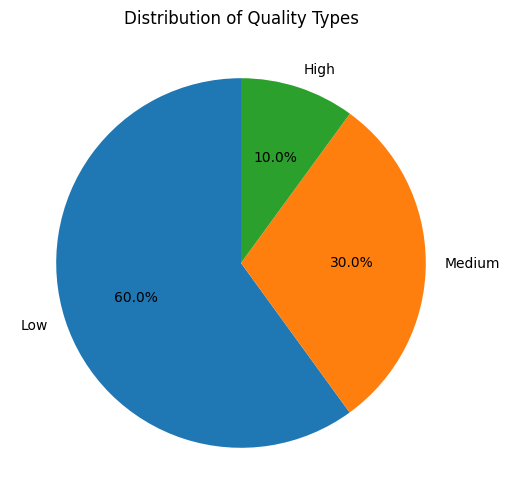

In [15]:
# Visualizing Quality Types (pie chart)
plt.figure(figsize=(6, 6))
plt.title('Distribution of Quality Types')
plt.pie([low, med, high], labels=['Low', 'Medium', 'High'], autopct='%1.1f%%', startangle=90)
plt.show()

This pie chart illustrates that, within this dataset, 60% of the manufactured products are of low quality, 30% are of medium quality, and 10% are of high quality.

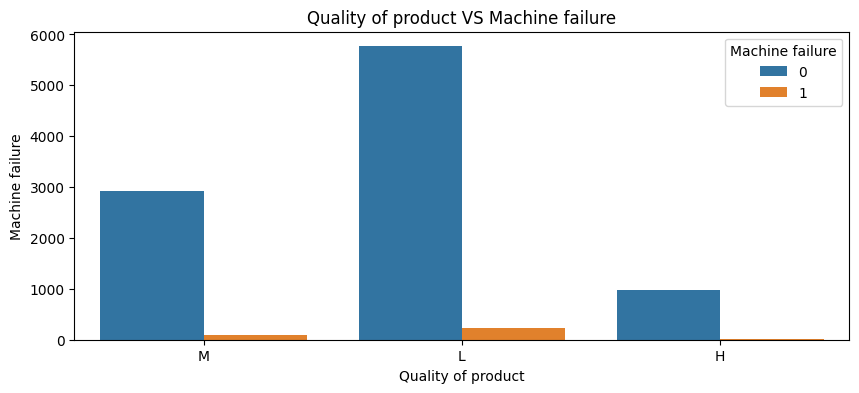

In [16]:
# visualizing Machine failure based on product Quality
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Type', hue='Machine failure')
plt.title('Quality of product VS Machine failure')
plt.xlabel('Quality of product')
plt.ylabel('Machine failure')
plt.show()

For this graph, it is possible to see that almost no high-quality products are related to machine failure. On the other hand, almost all failures occur during the manufacturing of low-quality products.

### Data Correlation

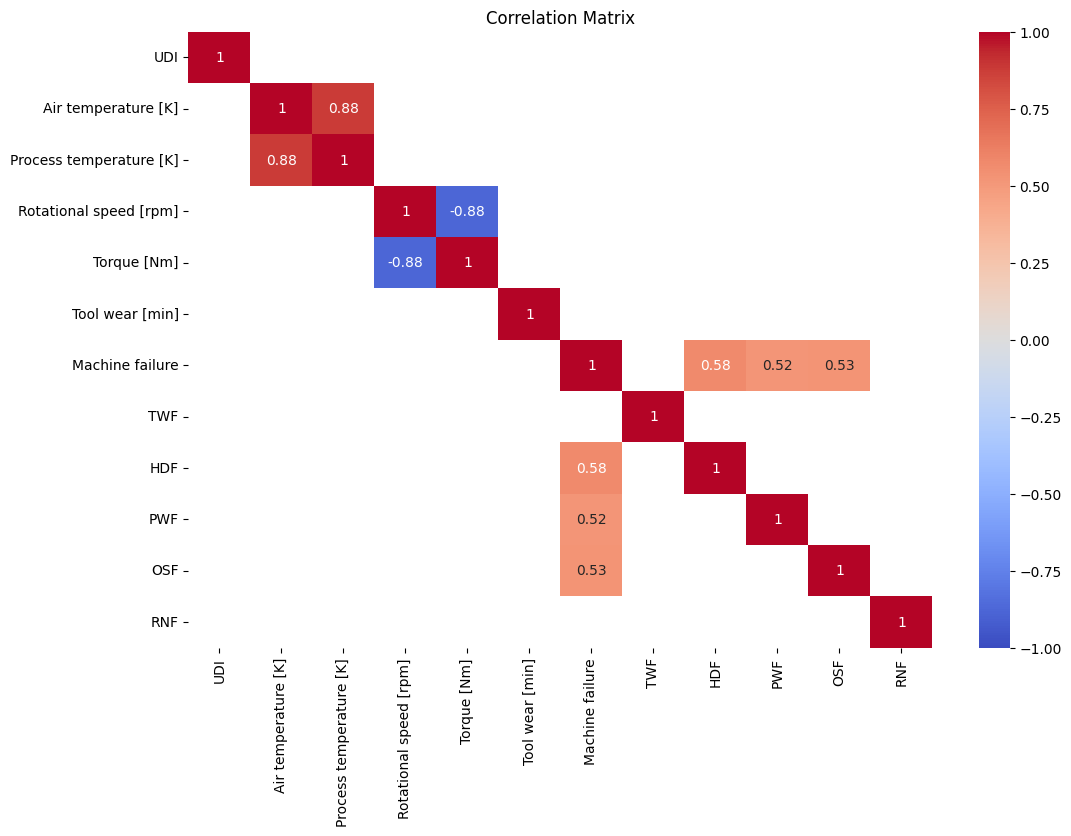

In [17]:
# Select only numeric columns for correlation matrix
numeric_cols = main_df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix (Threshold = 0.5)
corr_matrix = main_df[numeric_cols].corr()
threshold = 0.5
mask = np.abs(corr_matrix) < threshold

# Create a heatmap with masked irrelevant correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Air Temperature [K] and Process Temperature [K] = 0.88:** These two variables are both related to thermal dynamics within the machinery. The process temperature may depend directly on the ambient air temperature, especially in environments where machinery generates heat. A higher air temperature can make it harder to cool the system, resulting in a higher process temperature.

**Rotational Speed [rpm] and Torque [Nm] = -0.94:** In general, there is often an inverse relationship between rotational speed and torque. When the rotational speed of a machine increases, the torque required to maintain the same level of power decreases.


**Different failure types (HDF, PWF, OSF):** These correlations indicate that different failure modes (TWF, HDF, PWF, OSF) are often interconnected. For example, HDF and PWF could be related because inadequate heat dissipation can affect the electrical systems, leading to power failures.

### Histograms

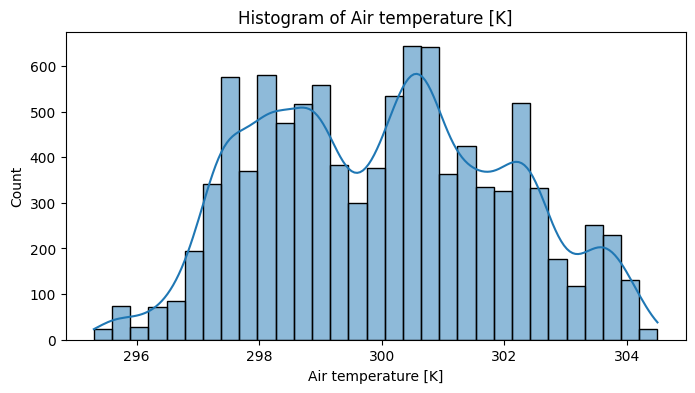

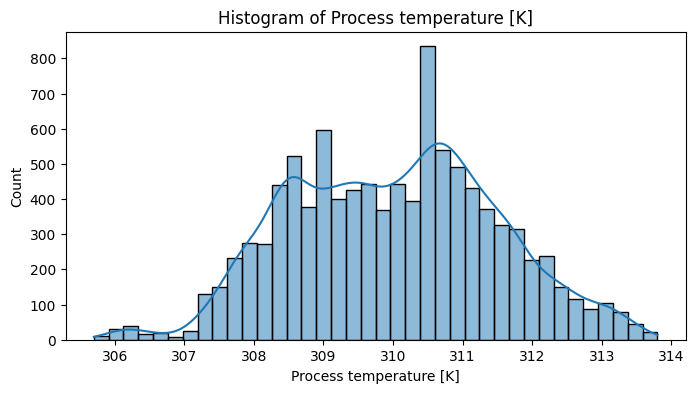

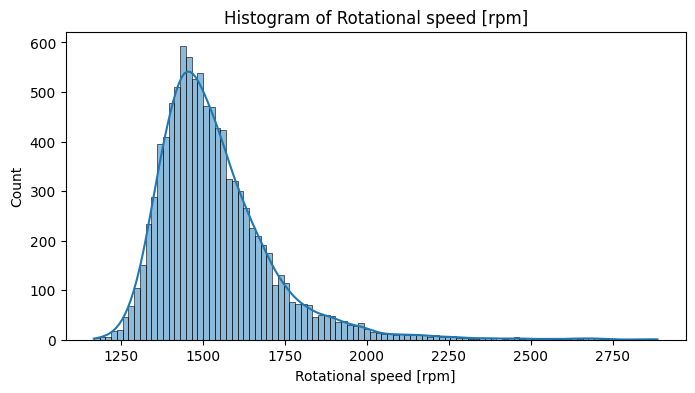

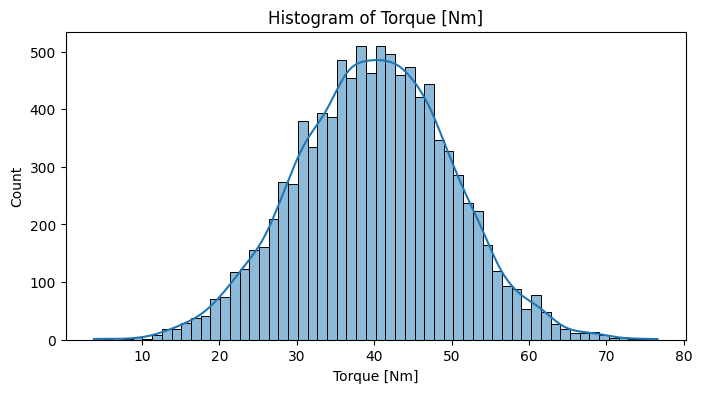

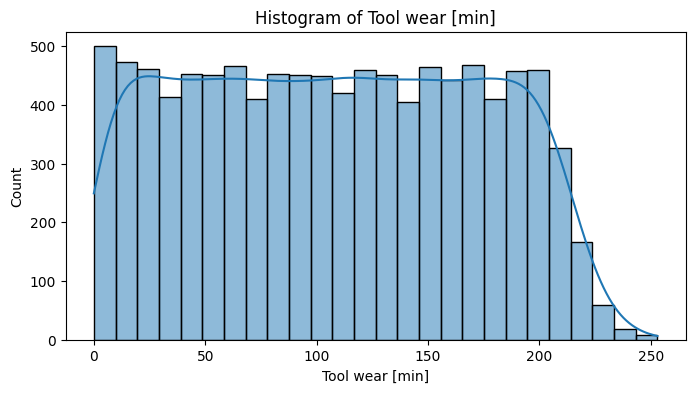

In [18]:
#  Histograms of features
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.show()

**Histogram of Air Temperature:** The distribution seems to be bimodal, where the temperatures are concetrated around 298 [k] and 301 [k].

**Histogram of Process Temperature:** The process temperature values range from about 306 K to 314 K, with most values concentrated between 309 K and 312 K. Also, the histogram displays a prominent peak between 310 [K] and 311 [k], what suggests that the majority of process temperatures cluster around this central value, However, there are some higher process temperatures that occur less frequently.

**Histogram of Rotational Speed:** The histogram displays a right-skewed distribution, with a peak around 1500 rpm. The histogram indicates that most of the data points are clustered around the lower end of the rotational speeds, with fewer instances of high speeds.

**Histogram of Torque:** The histogram shows a normal distribution of the machine torque. The mean torque is around 40 [Nm].

**Histogram of Tool Wear:** Tool wear generally ranges from 0 to 200 minutes of use. The distribution appears to be nearly uniform, but there is a sharp decline after 200 minutes of use.


## 3) Feature Engineering:

#### Note:
Based on the correlation matrix, we identified a strong inverse relationship between Rotational Speed [rpm] and Torque [Nm] (-0.94), and a strong positive correlation between Air Temperature [K] and Process Temperature [K] (0.88). To capture these important dynamics, we are creating two new features: Mechanical_Power, which combines torque and speed to represent the machine's total output, and Temp_Diff, which highlights differences between process and air temperature, potentially signaling abnormal conditions like overheating. These features will help us in predicting machine failures more effectively.

In [19]:
# Mechanical_Power: Product of Torque and Rotational speed
main_df['Mechanical_Power'] = main_df['Torque [Nm]'] * main_df['Rotational speed [rpm]']

Mechanical_Power: This feature is the product of Torque and Rotational speed.
It represents the total mechanical power exerted by the machine, which may be a critical factor in predicting machine failures, as higher power output could lead to increased stress on the machine components.

In [20]:
# Temp_Diff: Difference between Process temperature and Air temperature
main_df['Temp_Diff'] = main_df['Process temperature [K]'] - main_df['Air temperature [K]']

Temp_Diff: This feature represents the difference between Process temperature and Air temperature.
A significant difference might indicate abnormal operating conditions, such as overheating, which could contribute to machine failures.

#### Note:
As our goal is to predict whether any type of machine failure occurs. We are simplyfing the problem to a binary classification, by combining the failure mode ('TWF', 'HDF', 'PWF', 'OSF', 'RNF') columns into a single 'Any Failure' column.

In [21]:
# Combines failure mode columns into a single 'Any Failure' column
main_df['Any Failure'] = main_df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].any(axis=1).astype(int)

# Drops the individual failure mode columns
main_df = main_df.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'UDI', 'Product ID'], axis=1)

#### Note:
Here, we are using log transformation on the dataset to reduce the impact of extreme values (outliers) and normalize the distribution of skewed features like Rotational speed [rpm] and Torque [Nm], so the machine learning model can learn better and make more accurate predictions.

In [22]:
# Appling log transformation to Rotational Speed and Torque
main_df['Rotational speed [rpm]'] = np.log(main_df['Rotational speed [rpm]'] + 1)
main_df['Torque [Nm]'] = np.log(main_df['Torque [Nm]'] + 1)

# Shows the result of the transformation
print(main_df[['Rotational speed [rpm]', 'Torque [Nm]']].describe())

       Rotational speed [rpm]   Torque [Nm]
count            10000.000000  10000.000000
mean                 7.333330      3.680281
std                  0.107449      0.267251
min                  7.063904      1.568616
25%                  7.261225      3.532226
50%                  7.315884      3.716008
75%                  7.385851      3.867026
max                  7.967973      4.351567


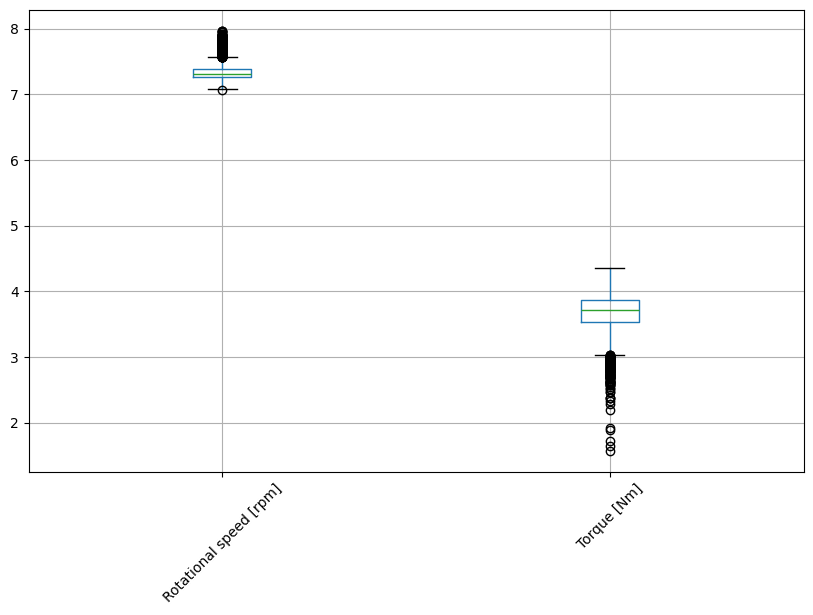

In [23]:
# Plots the transformed features
plt.figure(figsize = (10, 6))
main_df[['Rotational speed [rpm]', 'Torque [Nm]']].boxplot()
plt.xticks(rotation = 45)
plt.show()

After Log Transformation:
1) Rotational Speed [rpm]: After transformation the data is mostly concentrated around a tighter range , with a few outliers, but they are less extreme than before.

2) Torque [Nm]: The range is more compressed, and outliers on the lower end are also now much smaller in their impact on the distribution.

In [24]:
# Checks the result for the engineered features
print(main_df[['Mechanical_Power', 'Temp_Diff']].head())

   Mechanical_Power  Temp_Diff
0           66382.8       10.5
1           65190.4       10.5
2           74001.2       10.4
3           56603.5       10.4
4           56320.0       10.5


## 4) Modeling:

In [25]:
# Renames the columns to remove special characters
main_df.columns = main_df.columns.str.replace('[\[\]\s]', '_', regex=True)

In [26]:
# Train-Test Split
X = main_df.drop(['Any_Failure', 'Machine_failure'], axis=1)
y = main_df['Any_Failure']  # Target (Any Failure)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Applying SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 4.1) Feature Selection:

#### 1) Feature selection for Random Forest:

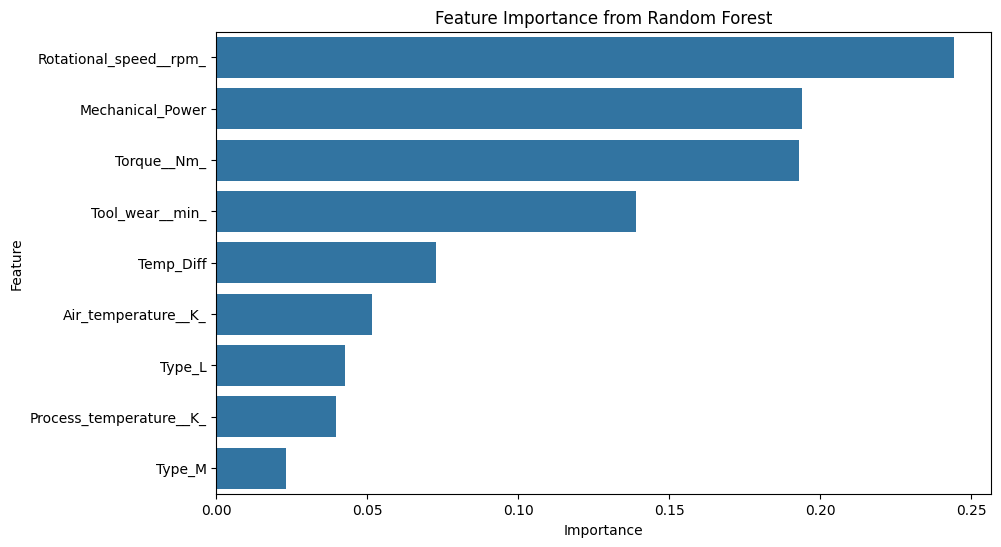

In [28]:
rf_model_fs = RandomForestClassifier(random_state=42)
rf_model_fs.fit(X_train_smote, y_train_smote)

# Checks the feature importance for Random Forest
importances_rf = rf_model_fs.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Plots top features for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importance from Random Forest')
plt.show()

In [29]:
# Selects the important features for Random Forest
selected_features_rf = importance_df_rf[importance_df_rf['Importance'] > 0.01]['Feature']
X_train_selected_rf = X_train[selected_features_rf]
X_test_selected_rf = X_test[selected_features_rf]

Selected Features for Random Forest Model:
   - Rotational speed [rpm]
   - Torque [Nm]
   - Mechanical_Power
   - Tool wear [min]
   - Temp_Diff
   - Air temperature [K]
   - Process temperature [K]
   - Type_M
   - Type_L

In [30]:
# Applying SMOTE to selected features for Random Forest
X_train_smote_selected_rf, y_train_smote_selected_rf = smote.fit_resample(X_train_selected_rf, y_train)

#### 2) Feature selection for Gradient Boosting:

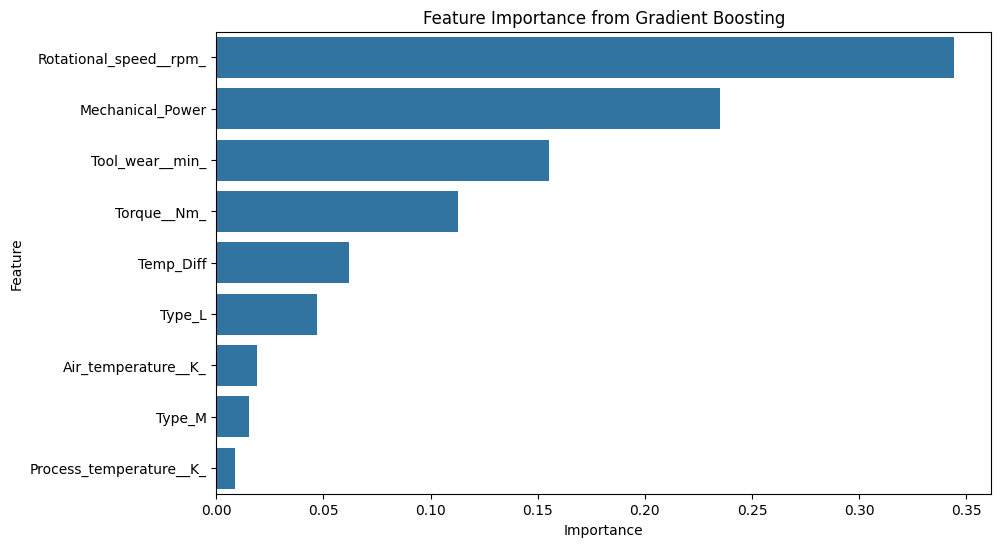

In [31]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_smote, y_train_smote)

# Checks the feature importance for Gradient Boosting
importances_gb = gb_model.feature_importances_
importance_df_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_gb})
importance_df_gb = importance_df_gb.sort_values(by='Importance', ascending=False)

# Plots top features for Gradient Boosting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_gb)
plt.title('Feature Importance from Gradient Boosting')
plt.show()

In [32]:
# Selects the important features for Gradient Boosting
selected_features_gb = importance_df_gb[importance_df_gb['Importance'] > 0.01]['Feature']
X_train_selected_gb = X_train[selected_features_gb]
X_test_selected_gb = X_test[selected_features_gb]

Selected Features for Gradient Boosting Model:
   - Rotational speed [rpm]
   - Mechanical_Power
   - Tool wear [min]
   - Torque [Nm]
   - Temp_Diff
   - Type_M
   - Air temperature [K]
   - Type_L
   - Process temperature [K]

In [33]:
# Applying SMOTE to selected features for Gradient Boosting
X_train_smote_selected_gb, y_train_smote_selected_gb = smote.fit_resample(X_train_selected_gb, y_train)

#### 3) Feature selection for XGBoost:

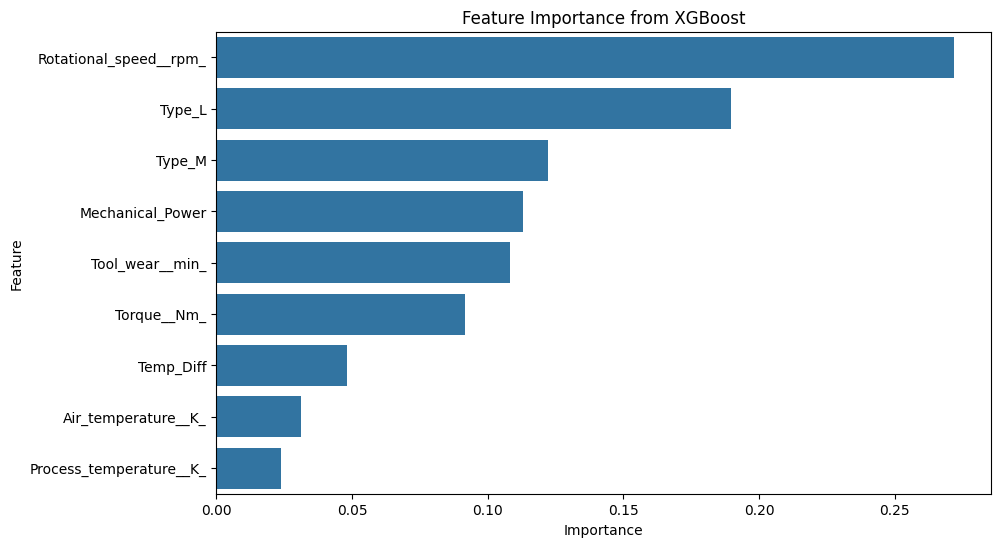

In [34]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Checks the feature importance for XGBoost
importances_xgb = xgb_model.feature_importances_
importance_df_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_xgb})
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

# Plots top features for XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb)
plt.title('Feature Importance from XGBoost')
plt.show()

In [35]:
# Selects the important features for XGBoost
selected_features_xgb = importance_df_xgb[importance_df_xgb['Importance'] > 0.01]['Feature']
X_train_selected_xgb = X_train[selected_features_xgb]
X_test_selected_xgb = X_test[selected_features_xgb]

Selected Features for XGBoost Model:
   - Rotational speed [rpm]
   - Type_M
   - Mechanical_Power
   - Tool wear [min]
   - Torque [Nm]
   - Type_L
   - Temp_Diff
   - Air temperature [K]
   - Process temperature [K]

In [36]:
# Applying SMOTE to selected features for XGBoost
X_train_smote_selected_xgb, y_train_smote_selected_xgb = smote.fit_resample(X_train_selected_xgb, y_train)

### 4.2) Training and Evaluating Models:

#### 1) Random Forest Model:

In [37]:
# Trains Random Forest model on SMOTE data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote_selected_rf, y_train_smote_selected_rf)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test_selected_rf)
print("Results for Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1935
           1       0.47      0.68      0.56        65

    accuracy                           0.96      2000
   macro avg       0.73      0.83      0.77      2000
weighted avg       0.97      0.96      0.97      2000

Accuracy: 0.965


#### 2) Gradient Boosting Model:

In [38]:
# Trains Gradient Boosting model on SMOTE data
gb_model_smote = GradientBoostingClassifier(random_state=42)
gb_model_smote.fit(X_train_smote_selected_gb, y_train_smote_selected_gb)

# Predictions and evaluation for Gradient Boosting
y_pred_gb = gb_model_smote.predict(X_test_selected_gb)
print("Results for Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")

Results for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1935
           1       0.32      0.78      0.45        65

    accuracy                           0.94      2000
   macro avg       0.65      0.86      0.71      2000
weighted avg       0.97      0.94      0.95      2000

Accuracy: 0.938


#### 3) XGBoost Model:

In [39]:
# Trains XGBoost model on SMOTE data
xgb_model_smote = XGBClassifier(random_state=42)
xgb_model_smote.fit(X_train_smote_selected_xgb, y_train_smote_selected_xgb)

# Predictions and evaluation for XGBoost
y_pred_xgb = xgb_model_smote.predict(X_test_selected_xgb)
print("Results for XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")

Results for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1935
           1       0.64      0.72      0.68        65

    accuracy                           0.98      2000
   macro avg       0.82      0.85      0.83      2000
weighted avg       0.98      0.98      0.98      2000

Accuracy: 0.978


#### Note:
Random Forest and Gradient Boosting performed well, achieving high accuracy. However, XGBoost provided the best balance between precision (correct positive predictions) and recall (detecting most failures). So, we are applying threshold tuning only to XGBoost because it outputs probability scores, allowing us to adjust the balance between precision and recall.This helps us catch more failures (improve recall) without creating too many false positives.

##### Threshold Tuning

In [40]:
# Gets the predicted probabilities (for class 1) instead of labels
y_prob_xgb = xgb_model_smote.predict_proba(X_test_selected_xgb)[:, 1]

In [41]:
# Define a range of thresholds to test
thresholds = np.arange(0.1, 0.9, 0.1)

In [42]:
# Store precision, recall, and accuracy for each threshold
for thresh in thresholds:
    # Convert probabilities to predictions based on the threshold
    y_pred_thresh = (y_prob_xgb >= thresh).astype(int)

    # Evaluate the model performance for this threshold
    print(f"Threshold: {thresh}")
    print(classification_report(y_test, y_pred_thresh))
    print(f"Accuracy: {accuracy_score(y_test, y_pred_thresh)}")
    print("-" * 60)

Threshold: 0.1
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1935
           1       0.32      0.80      0.45        65

    accuracy                           0.94      2000
   macro avg       0.65      0.87      0.71      2000
weighted avg       0.97      0.94      0.95      2000

Accuracy: 0.9375
------------------------------------------------------------
Threshold: 0.2
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1935
           1       0.39      0.75      0.51        65

    accuracy                           0.95      2000
   macro avg       0.69      0.86      0.74      2000
weighted avg       0.97      0.95      0.96      2000

Accuracy: 0.9535
------------------------------------------------------------
Threshold: 0.30000000000000004
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1935
           1       0

In [43]:
# Use the chosen threshold (0.3)
threshold = 0.3
y_pred_xgb_thresh = (y_prob_xgb >= threshold).astype(int)

# Evaluate the model performance with the chosen threshold
print(f"Results for XGBoost with SMOTE and Threshold {threshold}:")
print(classification_report(y_test, y_pred_xgb_thresh))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_thresh)}")

Results for XGBoost with SMOTE and Threshold 0.3:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1935
           1       0.49      0.74      0.59        65

    accuracy                           0.97      2000
   macro avg       0.74      0.86      0.79      2000
weighted avg       0.97      0.97      0.97      2000

Accuracy: 0.967


#### Note:
After threshold tuning (with a threshold of 0.3), XGBoost gave a better trade-off between precision and recall. It maintained high recall (capturing most failures) while keeping a good precision (reducing false positives).

### 5) Scaling

#### Note:
We are applying scaling before using AdaBoost and Logistic Regression models because they are sensitive to the scale of features. Standardizing the features will ensure that each feature contributes equally, potentially improving our model performance. For tree-based models (Random Forest, Gradient Boosting, XGBoost), we don't applied scaling, as these models split data based on thresholds and are inherently unaffected by feature scale.

In [44]:
# Columns to scale
columns_scale = ['Air_temperature__K_', 'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_', 'Tool_wear__min_']

# Initializes the StandardScaler
scaler = StandardScaler()

# Applying scaling to the selected columns
main_df[columns_scale] = scaler.fit_transform(main_df[columns_scale])

# Shows the result of the scaling
print(main_df[columns_scale].describe())

       Air_temperature__K_  Process_temperature__K_  Rotational_speed__rpm_  \
count         1.000000e+04             1.000000e+04            1.000000e+04   
mean         -9.322321e-16            -1.693934e-15            3.573319e-15   
std           1.000050e+00             1.000050e+00            1.000050e+00   
min          -2.352278e+00            -2.901986e+00           -2.507604e+00   
25%          -8.523974e-01            -8.125581e-01           -6.710940e-01   
50%           4.753123e-02             6.365340e-02           -1.623766e-01   
75%           7.474757e-01             7.376623e-01            4.888265e-01   
max           2.247357e+00             2.557486e+00            5.906760e+00   

        Torque__Nm_  Tool_wear__min_  
count  1.000000e+04     1.000000e+04  
mean  -6.849632e-16     1.051603e-16  
std    1.000050e+00     1.000050e+00  
min   -7.901834e+00    -1.695984e+00  
25%   -5.540204e-01    -8.633176e-01  
50%    1.336923e-01     7.698234e-04  
75%    6.987988

In [45]:
# Train-Test Split
X = main_df.drop(['Any_Failure', 'Machine_failure'], axis=1)
y = main_df['Any_Failure']  # Target (Any Failure)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Applying SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### 5.1) AdaBoost Model:

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


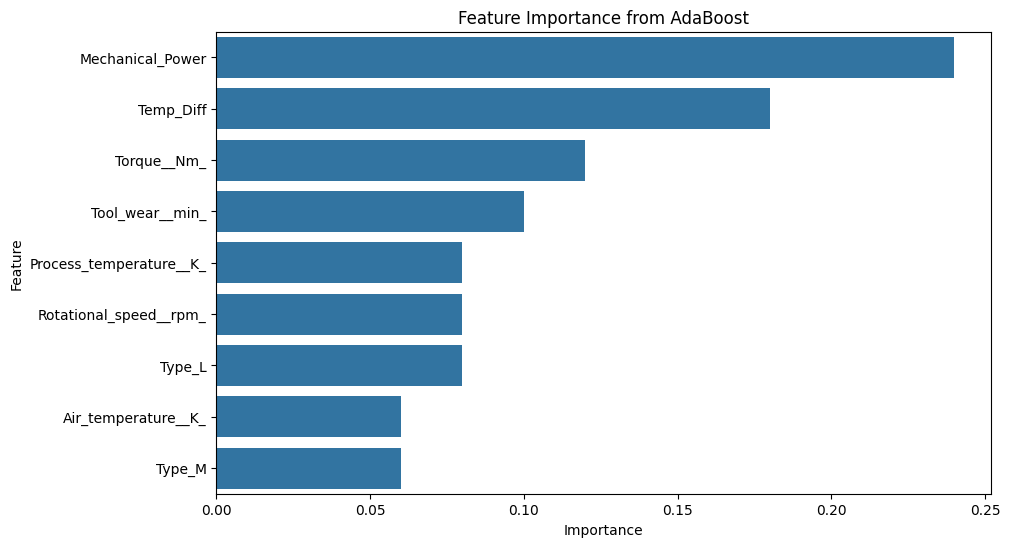

In [47]:
ada_model_fs = AdaBoostClassifier(random_state=42)
ada_model_fs.fit(X_train_smote, y_train_smote)

# Checks the feature importance for AdaBoost
importances_ada = ada_model_fs.feature_importances_
importance_df_ada = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_ada})
importance_df_ada = importance_df_ada.sort_values(by='Importance', ascending=False)

# Plots top features for AdaBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_ada)
plt.title('Feature Importance from AdaBoost')
plt.show()

In [48]:
# Selects the important features for AdaBoost
selected_features_ada = importance_df_ada[importance_df_ada['Importance'] > 0.01]['Feature']
X_train_selected_ada = X_train[selected_features_ada]
X_test_selected_ada = X_test[selected_features_ada]

Selected Features for AdaBoost Model:

   - Mechanical_Power
   - Temp Diff
   - Torque [Nm]
   - Tool wear [min]
   - Process temperature [K]
   - Rotational speed [rpm]
   - Type_L
   - Air temperature [K]
   - Type_M

In [49]:
# Applying SMOTE to selected features for AdaBoost
X_train_smote_selected_ada, y_train_smote_selected_ada = smote.fit_resample(X_train_selected_ada, y_train)

In [50]:
# Trains AdaBoost model on SMOTE data
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train_smote_selected_ada, y_train_smote_selected_ada)

# Predictions and evaluation
y_pred_ada = ada_model.predict(X_test_selected_ada)
print("Results for AdaBoost Classifier:")
print(classification_report(y_test, y_pred_ada))
print(f"Accuracy: {accuracy_score(y_test, y_pred_ada)}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1935
           1       0.22      0.75      0.34        65

    accuracy                           0.90      2000
   macro avg       0.60      0.83      0.64      2000
weighted avg       0.97      0.90      0.93      2000

Accuracy: 0.904


#### Note:
The AdaBoost model performed reasonably well, achieving a high precision for the majority class (0) but showing limited recall and precision for the minority class (1). Compared to the tree-based models, AdaBoost had a lower overall accuracy and struggled with detecting failures, as seen in its lower f1-score for class 1.

#### 5.2) Logistic Regression Model:

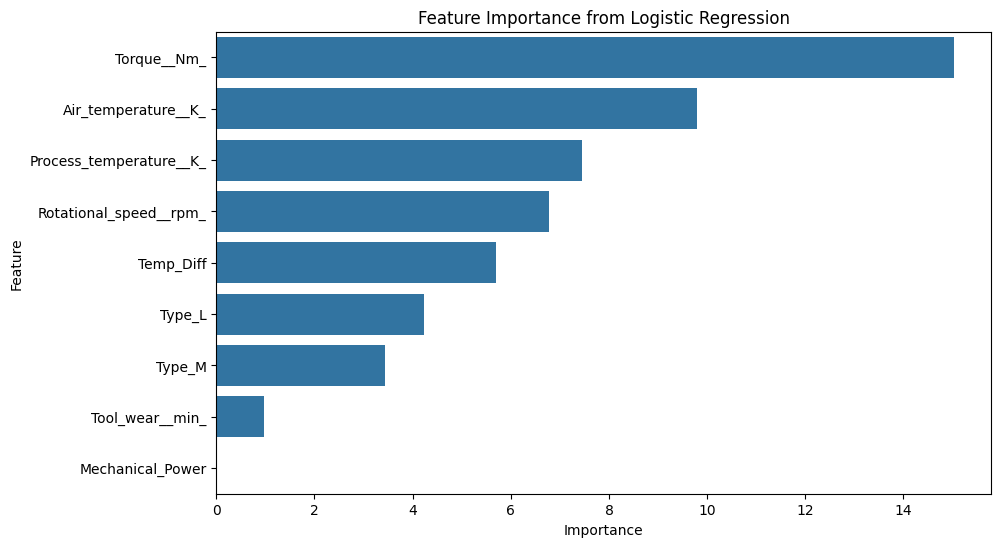

In [51]:
LR_model_fs = LogisticRegression(random_state=42, max_iter=2000)
LR_model_fs.fit(X_train_smote, y_train_smote)

importances_LR = LR_model_fs.coef_[0]
importance_df_LR = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_LR})
importance_df_LR['Importance'] = importance_df_LR['Importance'].abs()  # Get absolute values
importance_df_LR = importance_df_LR.sort_values(by='Importance', ascending=False)

# Plot top features for Logistic Regression
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_LR)
plt.title('Feature Importance from Logistic Regression')
plt.show()

In [52]:
# Selects the important features for LogisticRegression
selected_features_LR = importance_df_LR[importance_df_LR['Importance'] > 1]['Feature']
X_train_selected_LR = X_train[selected_features_LR]
X_test_selected_LR = X_test[selected_features_LR]

Selected Features for Logistic Regression Model:

   - Torque [Nm]
   - Air temperature [K]
   - Process temperature [K]
   - Rotational speed [rpm]
   - Temp Diff
   - Type_L
   - Type_M
   - Tool wear [min]
   - Mechanical_Power

In [53]:
# Applying SMOTE to selected features for LogisticRegression
X_train_smote_selected_LR, y_train_smote_selected_LR = smote.fit_resample(X_train_selected_LR, y_train)

In [54]:
# Trains LogisticRegression model on SMOTE data
LR_model = LogisticRegression(random_state=42)
LR_model.fit(X_train_smote_selected_LR, y_train_smote_selected_LR)

# Predictions and evaluation
y_pred_LR = LR_model.predict(X_test_selected_LR)
print("Results for LogisticRegression Classifier:")
print(classification_report(y_test, y_pred_LR))
print(f"Accuracy: {accuracy_score(y_test, y_pred_LR)}")

Results for LogisticRegression Classifier:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1935
           1       0.07      0.63      0.12        65

    accuracy                           0.70      2000
   macro avg       0.53      0.67      0.47      2000
weighted avg       0.95      0.70      0.80      2000

Accuracy: 0.705


#### Note:
The Logistic Regression model, even with feature selection and scaling, struggled to identify the minority class (1). It achieved a lower accuracy and lower recall for class 1 compared to the other models, likely due to its linear nature, which makes it less effective on our dataset's complex patterns. The tree-based models, with their non-linear capabilities, captured these patterns better, especially for predicting failures (class 1).

### 6) Conclusion:

Our project successfully developed a predictive maintenance model aimed at identifying potential machine failures, enabling proactive and cost-effective maintenance interventions. We implemented several critical steps using the AI4I 2020 dataset, including feature engineering (e.g., Mechanical Power and Temperature Difference) and SMOTE, to address class imbalance and enhance model training. Among the models tested—Random Forest, Gradient Boosting, AdaBoost, Logistic Regression, and XGBoost—the XGBoost model emerged as the best performer with an accuracy of 97.35% and an F1-score of 0.65 for the minority class. This model showed strong precision and recall metrics, capturing both positive and negative failure cases effectively, especially when tuned to an optimal threshold. The XGBoost model’s performance relied on features like Rotational Speed, Torque, and Mechanical Power, providing insights into factors most indicative of potential failures. To maintain this model’s effectiveness, periodic retraining with updated data is recommended to keep the model adaptive to evolving machine behaviors and operational changes. This predictive maintenance solution holds significant potential for reducing downtime, optimizing repair schedules, and lowering overall maintenance costs in industrial applications.